In [1]:
import os
import rioxarray

import rasterio as rio
import rsfuncs as rs
import numpy as np
import pandas as pd
import geopandas as gp
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from shapely.geometry import Point
from datetime import datetime
from scipy.signal import savgol_filter
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set()

In [2]:
# Setup the directories
working_dir = os.getcwd()
shp_dir = os.path.join(os.path.split(os.getcwd())[0], "shape")
files = [os.path.join(shp_dir,x) for x in os.listdir(shp_dir) if "ca" in x if "amflux" in x if x.endswith(".csv")]

# Read the ameriflux csv with all the sites
df = pd.read_csv(files[0], error_bad_lines=False, sep='\t')

# Convert the sites CSV (prefiltered for CA) to a gdf 
df.rename(columns={'Longitude (degrees)': 'Lon', 'Latitude (degrees)': 'Lat', 'Site Id': 'id' }, inplace = True)
geometry = [Point(xy) for xy in zip(df.Lon, df.Lat)]
crs = {'init': 'epsg:4326'}
gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf['Lat'] = df['Lat']
gdf['Lon'] = df['Lon']

In [3]:
# Loop through each site ID, and extract the matching zipfile zips to the amflux_ca_data dir 
# All USA Ameriflux predownloaded in ../amflux_data

data_dir = os.path.join(os.getcwd(), "../amflux_data")
ca_dir = os.path.join(os.getcwd(), "../amflux_ca_data")

sids = sorted(gdf.id.unique())

for i in sids:
    file = [os.path.join(data_dir,x ) for x in os.listdir(data_dir) if i in x][0]
    os.chdir(ca_dir)
    cmd_str = "tar -xvf {}".format(file)
    if os.path.exists(file):
        continue
    else:
        print(cmd_str)
        os.system(cmd_str)


In [4]:
# Find and sort the unzipped files
ca_files = [os.path.join(ca_dir, x) for x in os.listdir(ca_dir) if x.endswith(".csv")]
ca_files.sort()

# Read as dfs 
ca_dfs = [pd.read_csv(x, skiprows = 2) for x in ca_files]

In [5]:
# Filter for what we want - latent heat flux and measurement date. And compute the data record len for each site 

outdir = os.path.join(os.getcwd(),'amflux_monthly')
mdfs = []
site_lens = {}

# Loop through the dfs
for idx,i in enumerate(ca_dfs[:]):
    
    # check if we already did this 
    site_id = sids[idx]
    outfn = os.path.join(outdir, site_id + ".csv")
    
    if os.path.exists(outfn):
        print("already processed {}".format(outfn))
        mdf = pd.read_csv(outfn)
        pmdf = rs.col_to_dt(mdf)
        mdfs.append(pmdf)
        continue
    
    start = datetime.strptime(str(i.TIMESTAMP_START[0]), "%Y%m%d%H%M")
    end = datetime.strptime(str(i.TIMESTAMP_START[-1:].values[0]), "%Y%m%d%H%M")
    
    nyears = round(((end-start).days/ 365.2425), 2)
    
    site_lens[sids[idx]] = [nyears]
    
    print("Processing {} years of data for site no {}".format(nyears, sids[idx]))
        
    startvals = i.TIMESTAMP_START
    endvals = i.TIMESTAMP_END

    starts = [datetime.strptime(str(j), "%Y%m%d%H%M") for j in startvals]    
    ends = [datetime.strptime(str(f), "%Y%m%d%H%M") for f in endvals]    
    
    LE_col = [x for x in i.columns if "LE" in x if "P" not in x if "TEST" not in x if "MO" not in x][0]

    LE = i[LE_col]

    filtered = pd.DataFrame([starts,ends,LE]).T
    filtered.columns = ['start','end','LE']
    filtered['id'] = sids[idx]
    
    # Further filter
    cdf = filtered[filtered['LE'] != -9999] # filter nans
    cdf = cdf[cdf['LE'] != 0] # filter absolute zeros
    cdf.start = pd.to_datetime(cdf.start) # Make the dates datetime
    cdf.set_index(cdf.start, inplace = True) # Set dates as index

    # convert LH to ET 
    cor = i.LE.astype(np.float32) * 0.00072  # Apply the 30min conversion from W/m^2 to mm
    sdf = pd.DataFrame([cor.resample("MS").sum()]).T
    sdf['id'] = i.id[0]
    
    mdfs.append(sdf) # append to list
    
    sdf.to_csv(outfn)    # write
    


already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-Bi1.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-Bi2.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-Blo.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-CZ2.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-CZ3.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-CZ4.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-Dia.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-EDN.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-Lin.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-Myb.csv
already processed /Users/aakash/Desktop/AmeriFlux/amflux_ca_data/amflux_monthly/US-SCd.csv

In [6]:
'''
Here is the math to convert from latent head to ET (mm)

Convert W/m^2 to mm like: 

Conversion of W m-2 to mm of water
Unit of LE is W m-2 or J m-2 s-1
L = 2.5 MJ kg-1 (latent heat of evaporation of water)
m2 = 100 00 cm2
Kg = 1000 g /ρ =1000 cm3 (ρ, density of water = 1 g/cm3 )
ET is Latent heat energy divided latent heat of vaporization of water: ET = LE/L = J m-2 s-1 /2.5 MJ kg-1
= J m-2 s-1 /2.5 MJ kg-1
= J kg /2.5 MJ m2 s
Substituting for kg of water and m2 to cm2:
= J 1000 cm3 /2.5 MJ 10000 cm2 s
= J cm3 /2.5 MJ 10 cm2 s
= cm /25 M s
= mm/2.5 106 s
= 0.00 00 00 4 mm/s In 30 minutes,
= 1800 * 0.00 00 00 4 mm/s
=0.00072 mm/30 min (varies between 0.00072 and 0.00074 depending on the temperature at latent heat of evaporation of water was assumed) Is this not the same.
'''



'\nHere is the math to convert from latent head to ET (mm)\n\nConvert W/m^2 to mm like: \n\nConversion of W m-2 to mm of water\nUnit of LE is W m-2 or J m-2 s-1\nL = 2.5 MJ kg-1 (latent heat of evaporation of water)\nm2 = 100 00 cm2\nKg = 1000 g /ρ =1000 cm3 (ρ, density of water = 1 g/cm3 )\nET is Latent heat energy divided latent heat of vaporization of water: ET = LE/L = J m-2 s-1 /2.5 MJ kg-1\n= J m-2 s-1 /2.5 MJ kg-1\n= J kg /2.5 MJ m2 s\nSubstituting for kg of water and m2 to cm2:\n= J 1000 cm3 /2.5 MJ 10000 cm2 s\n= J cm3 /2.5 MJ 10 cm2 s\n= cm /25 M s\n= mm/2.5 106 s\n= 0.00 00 00 4 mm/s In 30 minutes,\n= 1800 * 0.00 00 00 4 mm/s\n=0.00072 mm/30 min (varies between 0.00072 and 0.00074 depending on the temperature at latent heat of evaporation of water was assumed) Is this not the same.\n'

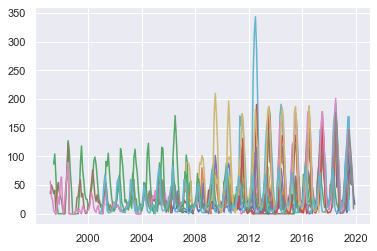

In [7]:
for i in mdfs[:]:
    plt.plot(i.LE)

In [8]:
# Calc mean Et and data record at each site 

site_means = {}
site_lens = {}

for i in mdfs:
    sid = i.id[0]
    site_means[sid] = [np.mean(i.LE)]

    start = i.index[0] 
    end = i.index[-1]
    nyears = round(((end-start).days/ 365.2425), 4)
    site_lens[sid] = [nyears]
        
sitemeans = pd.DataFrame.from_dict(site_means).T
sitemeans.columns = ['ET_mean']

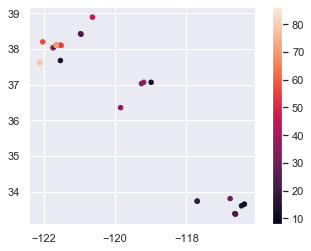

In [9]:
sitelens = pd.DataFrame.from_dict(site_lens).T
sitelens.columns = ['nyears']

merged1 = pd.merge(gdf,sitemeans, left_on = 'id', right_index = True)
amgdf = pd.merge(merged1,sitelens, left_on = 'id', right_index = True)

amgdf.plot(column = 'ET_mean', markersize = 20, legend = True)

# Read or get the SSEBop ET netcdf data

In [10]:
# in case you want to download do this:

# Get the bbox of the amflux data 
minx, miny, maxx, maxy = amgdf.geometry.total_bounds

# Get the ssebop data by bbox 
comstr = '''curl -o ../data/ssebop.nc https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north={}&west={}&east={}&south={}&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2019-10-01T00%3A00%3A00Z&timeStride=1'''.format(maxy, minx, maxx, miny)

# Run following string from command line, and put it in the ssebop_data dir 
print(comstr)

curl -o ../data/ssebop.nc https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north=38.8953&west=-122.114&east=-116.37213999999999&south=33.3738&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2019-10-01T00%3A00%3A00Z&timeStride=1


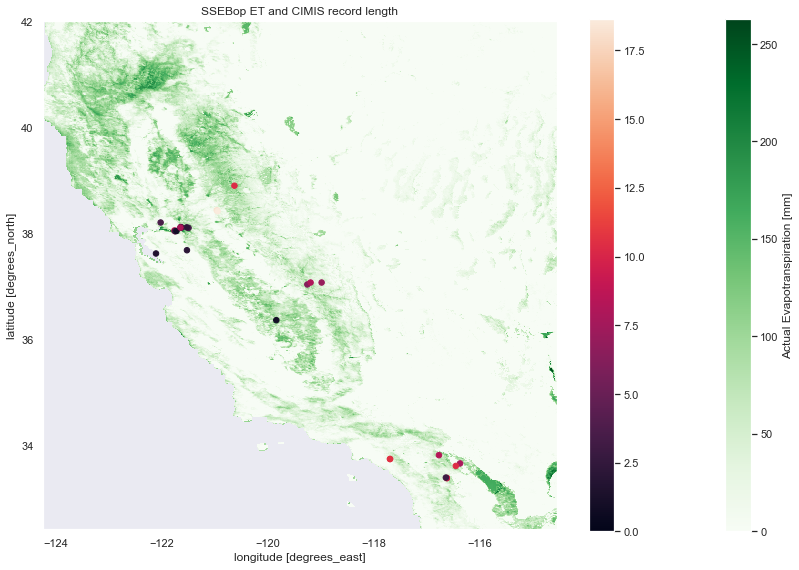

In [11]:
# In our case we already have the data, so read it in and plot a sample 

files = [os.path.join("../ssebop_data",x) for x in os.listdir("../ssebop_data") if x.endswith(".nc")]
ds = xr.open_dataset(files[0])

fig, ax=plt.subplots(figsize = (12,8))
ds['et'][8].plot(ax = ax, cmap = 'Greens')
amgdf.plot(column = 'nyears', markersize = 30, legend = True, vmin = 0, ax = ax)
plt.title("SSEBop ET and CIMIS record length")
plt.tight_layout()

In [12]:
def geo_idx(dd, dd_array):
    """
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    """
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]


In [13]:
# Compile the in situ data
all_ameriflux_dat = pd.concat(mdfs)

# Filter out the months outside the ssebop range
ssebop_start = ds.time[0].values
ssebop_end = ds.time[-1].values

mask = (all_ameriflux_dat.index > ssebop_start) & (all_ameriflux_dat.index <= ssebop_end)
dat = all_ameriflux_dat[mask]


In [14]:
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]

outdfs = []

for i in amgdf.id.unique()[:]:

    flux_dat = dat[dat.id == i]

    # Extract lat / long value from SSEBop 
    in_lat = np.array(amgdf[amgdf.id==i].Lat)
    in_lon = np.array(amgdf[amgdf.id==i].Lon)

    lat_idx = geo_idx(in_lat, lats)
    lon_idx = geo_idx(in_lon, lons)

    # Compile the out data 
    for j in flux_dat.index[:]:
        
        ymd = j.strftime('%Y-%m-%d')        
        tempdf = pd.DataFrame([i, ymd, flux_dat[flux_dat.index == j].LE.values[0], ds.sel(time=j)['et'][lat_idx, lon_idx].values]).T
        tempdf.columns = ['id','date', 'amflux_et', 'ssebop_et']
        
        outdfs.append(tempdf)



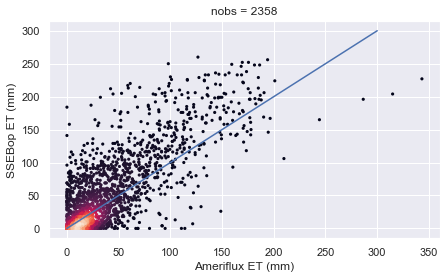

In [15]:
dataset = pd.concat(outdfs)

data = dataset.dropna()
valid = data[~np.isnan(data.ssebop_et.astype(float))]

x,y = valid.amflux_et.astype(float), valid.ssebop_et.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.plot([0,300],[0,300], label = '1-1 line')

plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("Ameriflux ET (mm)")
plt.show()

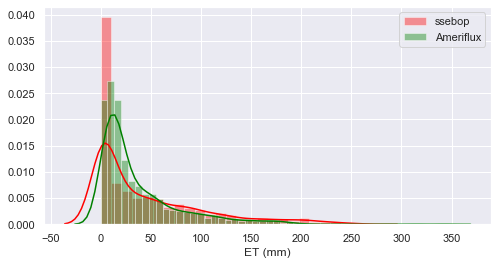

In [16]:
# Plot histograms and distributions

plt.figure(figsize=(8,4))
sns.distplot(valid.ssebop_et.astype(float), color = "red", label = "ssebop")
sns.distplot(valid.amflux_et.astype(float), color= "green", label = 'Ameriflux')
plt.xlabel("ET (mm)")
plt.legend()
plt.show()

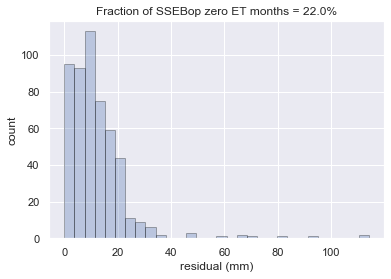

In [17]:
# For months where ssebop ET is zero, plot the corresponding CIMIS et 

ssebop_0 = data.loc[data['ssebop_et'] == 0]
plt.hist(ssebop_0.amflux_et.astype(float), bins = 30, alpha = 0.3, edgecolor='black')
plt.title("Fraction of SSEBop zero ET months = {}%".format(str(round(len(ssebop_0)/len(data),2)*100)))
plt.ylabel("count")
plt.xlabel("residual (mm)")
plt.show()

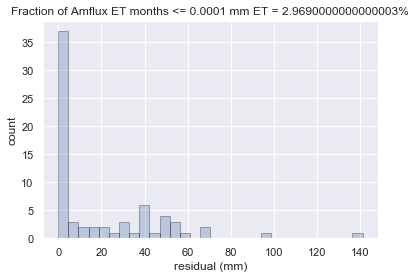

In [18]:
# For months where Amflux ET is zero, plot the corresponding SSEBop et 

cimis_0 = data.loc[data['amflux_et'] <= 0.001]
plt.hist(cimis_0.ssebop_et.astype(float), bins = 30, alpha = 0.3, edgecolor='black')
plt.title("Fraction of Amflux ET months <= 0.0001 mm ET = {}%".format(str(round(len(cimis_0)/len(data),5)*100)))
plt.ylabel("count")
plt.xlabel("residual (mm)")
plt.show()


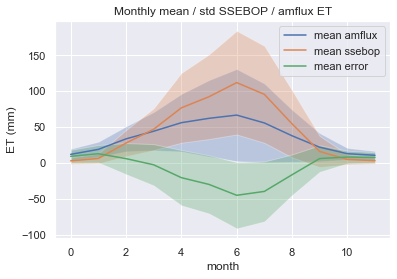

In [19]:
# Calculate the mean monthly error between SSEBop and amflux 

dataset = pd.concat(outdfs)

dataset.date = pd.to_datetime(dataset.date)

monthly_error_mean = []
monthly_error_std =[]
monthly_ssebop_mean = []
monthly_ssebop_std = []
monthly_amflux_mean = []
monthly_amflux_std = []

for i in range(1,13):
    # Select all rows for month i 
    mdf = dataset.loc[dataset['date'].dt.month==i]
    
    # Get amflux / ssebop stats 
    monthly_ssebop_mean.append(np.nanmean(mdf.ssebop_et))
    monthly_ssebop_std.append(np.nanstd(mdf.ssebop_et))
    monthly_amflux_mean.append(np.nanmean(mdf.amflux_et))
    monthly_amflux_std.append(np.nanstd(mdf.amflux_et))
    
    mresid = mdf.amflux_et - mdf.ssebop_et
    monthly_error_mean.append(np.nanmean(mresid))
    monthly_error_std.append(np.nanstd(mresid))

# +- 1 std
upper = np.array(monthly_error_mean) + np.array(monthly_error_std)
lower = np.array(monthly_error_mean) - np.array(monthly_error_std)

upper = upper.reshape(upper.shape[0])
lower = lower.reshape(lower.shape[0])

amflux_upper = np.array(monthly_amflux_mean) + np.array(monthly_amflux_std)
amflux_lower = np.array(monthly_amflux_mean) - np.array(monthly_amflux_std)

amflux_upper = amflux_upper.reshape(amflux_upper.shape[0])
amflux_lower = amflux_lower.reshape(amflux_lower.shape[0])

ssebop_upper = np.array(monthly_ssebop_mean) + np.array(monthly_ssebop_std)
ssebop_lower = np.array(monthly_ssebop_mean) - np.array(monthly_ssebop_std)


plt.plot(monthly_amflux_mean, label = 'mean amflux')
plt.fill_between(range(0,12),amflux_lower, amflux_upper, alpha = 0.3)

plt.plot(monthly_ssebop_mean, label = 'mean ssebop')
plt.fill_between(range(0,12),ssebop_lower, ssebop_upper, alpha = 0.3)

plt.plot(monthly_error_mean, label = 'mean error')
plt.fill_between(range(0,12),lower, upper, alpha = 0.3)
plt.ylabel("ET (mm)")
plt.title("Monthly mean / std SSEBOP / amflux ET")
plt.xlabel("month")
plt.legend()
plt.show()

In [20]:
# Plot mean error for each site 
dataset = pd.concat(outdfs)

site_errs_m = {}
site_errs_v = {}

for i in dataset.id.unique():
    # Select all rows for month i 
    mdf = dataset.loc[dataset['id']==i]
    err = mdf.amflux_et - mdf.ssebop_et
    site_errs_m[i] = [np.nanmean(err)]
    site_errs_v[i] = [np.nanvar(err)]

    
err_m_df = pd.DataFrame.from_dict(site_errs_m).T
err_v_df = pd.DataFrame.from_dict(site_errs_v).T

err_m_df.columns = ['mean_err']
err_v_df.columns = ['var_err']

err_df = pd.concat([err_m_df, err_v_df], axis = 1)


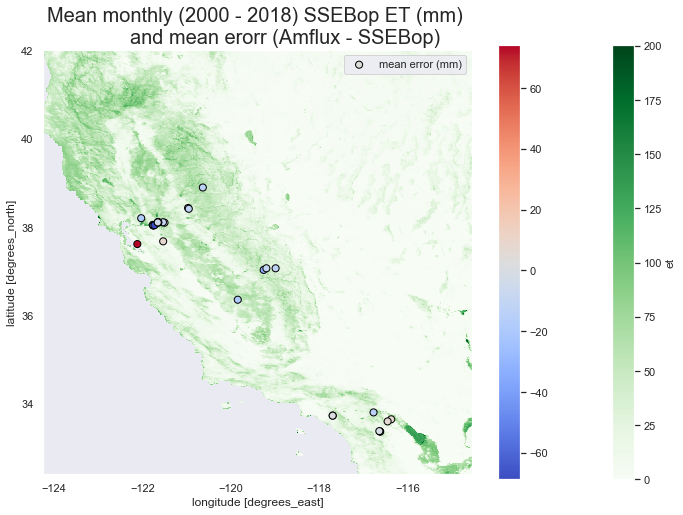

In [21]:
# Find the SSEBop mean ET and plot the errors at each site 

err_gdf = pd.merge(amgdf, err_df, left_on = "id", right_index = True)

et_mean = ds['et'].mean(axis = 0) # Spatial means 
et_mean = et_mean.where(et_mean!=180) # remove nans

fig, ax=plt.subplots(figsize = (12,8))
et_mean.plot(cmap = 'Greens',ax = ax)
err_gdf.plot(column = 'mean_err', markersize = 50, edgecolor = 'black', cmap = 'coolwarm',legend = True, label = "mean error (mm)", ax = ax)
plt.title('''Mean monthly (2000 - 2018) SSEBop ET (mm) 
          and mean erorr (Amflux - SSEBop)''', size = 20)
plt.legend()
plt.show()

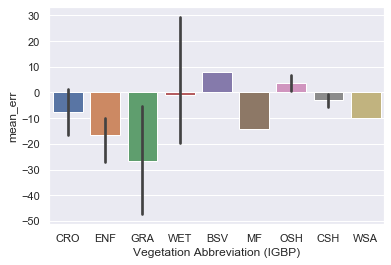

In [22]:
sns.barplot(x='Vegetation Abbreviation (IGBP)', y="mean_err", data=err_gdf)

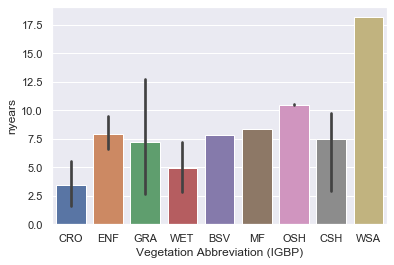

In [23]:
sns.barplot(x='Vegetation Abbreviation (IGBP)', y="nyears", data=err_gdf)

Text(0, 0.5, 'N sites')

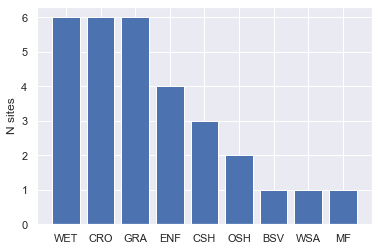

In [24]:
plt.bar(err_gdf['Vegetation Abbreviation (IGBP)'].value_counts().index, err_gdf['Vegetation Abbreviation (IGBP)'].value_counts())
plt.ylabel("N sites")

In [25]:
for i in err_gdf['Vegetation Description (IGBP)'].unique():
    lcdf = err_gdf[err_gdf['Vegetation Description (IGBP)'] == i]
    print(str(np.sum(lcdf.nyears.values)) + " years of data for {}".format(i))
    print("===="*10)

20.6629 years of data for Croplands: Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.
31.669400000000003 years of data for Evergreen Needleleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees remain green all year. Canopy is never without green foliage.
43.2507 years of data for Grasslands: Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water.
29.4188 years of data for Permanent Wetlands: Lands with a permanent mixture of water and herbaceous or woody vegetation that cover extensive areas. The vegetation can be present in either salt, brackish, or fresh w

In [26]:
def xarray_to_rasterio(xa, output_filename):
    """Converts the given xarray.DataArray object to a raster output file
    using rasterio.
    Arguments:
     - `xa`: The xarray.DataArray to convert
     - `output_filename`: the filename to store the output GeoTIFF file in
    Notes:
    Converts the given xarray.DataArray to a GeoTIFF output file using rasterio.
    This function only supports 2D or 3D DataArrays, and GeoTIFF output.
    The input DataArray must have attributes (stored as xa.attrs) specifying
    geographic metadata, or the output will have _no_ geographic information.
    If the DataArray uses dask as the storage backend then this function will
    force a load of the raw data.
    """
    # Forcibly compute the data, to ensure that all of the metadata is
    # the same as the actual data (ie. dtypes are the same etc)
    xa = xa.load()

    if len(xa.shape) == 2:
        count = 1
        height = xa.shape[0]
        width = xa.shape[1]
        band_indicies = 1
    else:
        count = xa.shape[0]
        height = xa.shape[1]
        width = xa.shape[2]
        band_indicies = np.arange(count) + 1

    processed_attrs = {}

    try:
        val = xa.attrs['affine']
        processed_attrs['affine'] = rio.Affine.from_gdal(*val)
    except KeyError:
        pass

    try:
        val = xa.attrs['crs']
        print(val)
        processed_attrs['crs'] = rio.crs.CRS.from_string(val)
    except KeyError:
        pass

    with rio.open(output_filename, 'w',
                       driver='GTiff',
                       height=height, width=width,
                       dtype=str(xa.dtype), count=count,
                       **processed_attrs) as dst:
        dst.write(np.flipud(xa.values), band_indicies)


In [28]:
# Write the mean as a tiff 
ds.rio.set_spatial_dims('lat', 'lon')
ds.rio.write_crs("epsg:4326", inplace = True)
# xarray_to_rasterio(ds.et_m, '../ssebop_data/ssebop_monthly_mean.tif')

<xarray.Dataset>
Dimensions:      (lat: 1067, lon: 1077, time: 238)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-10-01
  * lat          (lat) float64 32.41 32.42 32.43 32.44 ... 41.99 42.0 42.01
  * lon          (lon) float64 -124.2 -124.2 -124.2 ... -114.6 -114.6 -114.6
    spatial_ref  int64 0
Data variables:
    et           (time, lat, lon) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:               CF-1.5
    _NCProperties:             version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Conterminous U.S. actual evapotranspiration data
    creator_name:              Stefanie Kagone
    creator_email:             skagone@contractor.usgs.gov
    summary:                   Actual ET (ETa) is produced using the operatio...
    cdm_data_type:             Grid
    date_created:              February, 2013
    date_modified:             December, 2019
    creator_url:               https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:            David Blodgett
    publisher_url:             https://cida.usgs.gov/
    publisher_email:           dblodgett@usgs.gov
    institution:               U.S. Geological Survey
    date_issued:               February, 2013
    project:                   WaterSMART National Water Census
    processing_level:          Refer to documentation.
    acknowledgement:           Senay, G.B., M. Budde, J.P. Verdin, and A.M. M...
    contributors:              Senay, G.B., S. Bohms, R. Singh, P.A. Gowda,  ...
    geospatial_lat_min:        32.413499999999985
    geospatial_lat_max:        42.007499999999986
    geospatial_lon_min:        -124.24049999999997
    geospatial_lon_max:        -114.55649999999997
    time_coverage_resolution:  P1Y
    license:                   Freely available
    History:                   Translated to CF-1.0 Conventions by Netcdf-Jav...
    grid_mapping:              spatial_ref

In [75]:
# For the clusters of proximal Ameriflux sites, compare the Ameriflux et and SSEBop et 

In [76]:
dataset = pd.concat(outdfs)

dataset.date = pd.to_datetime(dataset.date)
dataset.index = pd.to_datetime(dataset.date)

FH_N = ['US-Ton', 'US-Var']
GRA_N = ['US-Sne', 'US-Snd']
CRO_D = ['US-Twt', 'US-Tw3']
WET_D = ['US-Tw1', 'US-Tw2', 'US-Tw4', 'US-Tw5']
EVR_S = ['US-CZ2', 'US-CZ3', 'US-CZ4']
CS_S = ['US-SO2', 'US-SO3', 'US-SO4']
GRA_S = ['US-SCd', 'US-SCf']


<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, y)
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, y)


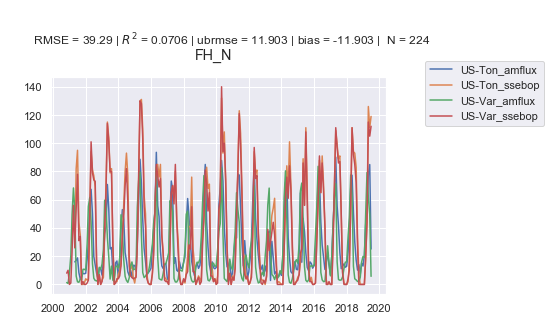

/anaconda3/envs/sci/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, y)
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=Non

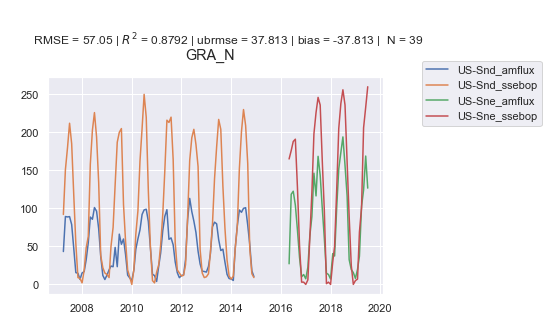

/anaconda3/envs/sci/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, y)
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=Non

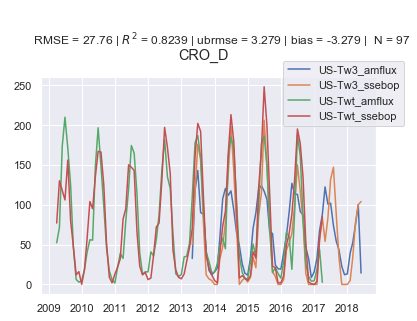

/anaconda3/envs/sci/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, y)
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=Non

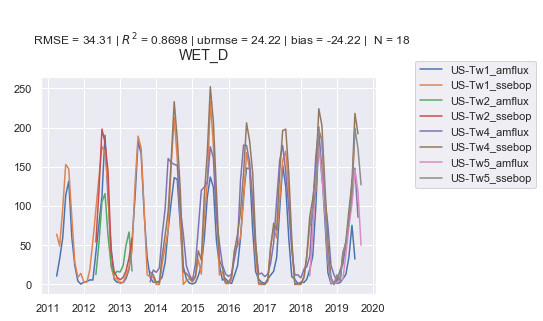

/anaconda3/envs/sci/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, y)
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=Non

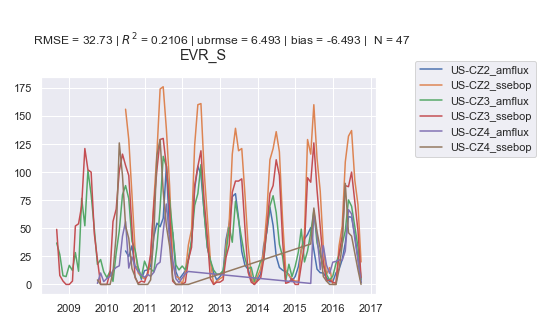

/anaconda3/envs/sci/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, y)
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=Non

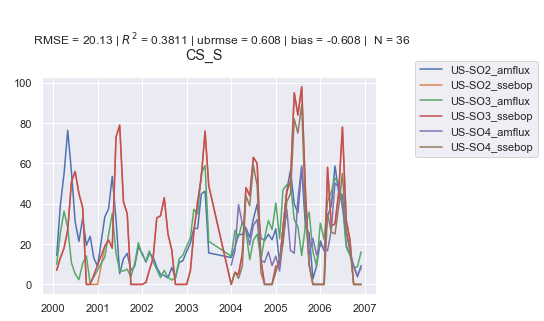

/anaconda3/envs/sci/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, y)
<ipython-input-78-987dc3338aa2>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=Non

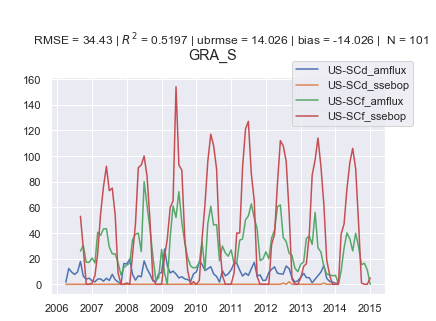

In [92]:
clusters = {
    "FH_N": ['US-Ton', 'US-Var'],
    "GRA_N": ['US-Sne', 'US-Snd'],  
    "CRO_D": ['US-Twt', 'US-Tw3'],
    "WET_D": ['US-Tw1', 'US-Tw2', 'US-Tw4', 'US-Tw5'],
    "EVR_S": ['US-CZ2', 'US-CZ3', 'US-CZ4'],
    "CS_S": ['US-SO2', 'US-SO3', 'US-SO4'],
    "GRA_S": ['US-SCd', 'US-SCf'],
}


for k,v in clusters.items():

    filt = dataset[dataset['id'].isin(v)]
    for i in filt.id.unique()[:]:
        
        filt.loc[filt['amflux_et'] == 0 ] = np.nan
        filt = filt.dropna()
        
        x, y = filt[filt.id==i].amflux_et.astype(float), filt[filt.id==i].ssebop_et.astype(float)
        
        rmse,r2,ubrmse,bias = calc_stats(x,y)
        
        plt.plot(filt[filt.id==i].amflux_et, label = str(i)+"_amflux")
        plt.plot(filt[filt.id==i].ssebop_et, label = str(i)+"_ssebop")
        plt.title('''

        RMSE = {} | $R^2$ = {} | ubrmse = {} | bias = {} |  N = {}

        '''.format(round(rmse,2), round(r2,4), round(ubrmse,3), round(bias,3), len(x)))
        plt.suptitle(k)
        plt.legend(bbox_to_anchor=(1.1, 1.1))
    plt.show()

In [78]:
# Function to calculate the stats we wish to evaluate: TODO Put this in RSfuncs 

def calc_stats(x,y):
    
    # RMSE
    rmse = float(np.sqrt(np.mean((x - y)**2)))

    A = np.vstack([x, np.ones(len(x))]).T
    solution = np.linalg.lstsq(A, y)

    m, c = solution[0]
    residuals = solution[1]
    
    # R^2
    r2 = float(1 - residuals / sum((y - y.mean())**2))

    # Calc ubRMSE
    ubrmse = float(np.sqrt(np.mean(((x - np.mean(y)) - (x - np.mean(x)))**2)))

    # Calc Bias 
    bias = float(np.mean(x - y))
    
    return rmse, r2,ubrmse,bias

In [ ]:
master = pd.merge(valid, err_gdf, left_on = "id", right_on = "id")

x,y= master['amflux_et'], master['ssebop_et']

rmse,r2,ubrmse,bias = calc_stats(x,y)

sns.lmplot(height = 4, aspect = 1.5, x="amflux_et", y="ssebop_et", data=master, fit_reg=False, hue='Vegetation Abbreviation (IGBP)', legend = True)
plt.plot([0,350],[0,350])
plt.title('''

        RMSE = {} | $R^2$ = {} | ubrmse = {} | bias = {} |  N = {}

        '''.format(round(rmse,2), round(r2,4), round(ubrmse,3), round(bias,3), len(x)))
plt.show()

In [ ]:
# Scatter by lc type 
master = pd.merge(valid, err_gdf, left_on = "id", right_on = "id")
color_labels = master['Vegetation Abbreviation (IGBP)'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", 9)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
# plt.figure(figsize = (10,8))

for i in master['Vegetation Abbreviation (IGBP)'].unique():
    lcdf = master[master['Vegetation Abbreviation (IGBP)'] == i]
    x,y= lcdf['amflux_et'], lcdf['ssebop_et']
    
    rmse,r2,ubrmse,bias = calc_stats(x,y)
    
    plt.scatter(x,y, c= [color_map[i]], label = str(i))
    plt.xlabel("amflux_et")
    plt.ylabel("ssebop_et")
    plt.plot([0,np.max(lcdf['amflux_et'])],[0,np.max(lcdf['amflux_et'])], label = '1-1 line')
    plt.title('''

            RMSE = {} | $R^2$ = {} | ubrmse = {} | bias = {} |  N = {}

            '''.format(round(rmse,2), round(r2,4), round(ubrmse,3), round(bias,3), len(x)))
    plt.legend()
    plt.show()
    

In [ ]:
for idx,x in enumerate (master['Vegetation Abbreviation (IGBP)'].unique()):
    print(x + "  =  " + master['Vegetation Description (IGBP)'].unique()[idx])


# Do the CIMIS based bias correction, and compare the same stats as above

In [ ]:
# Read the sites file and make a gdf 
sites = pd.read_excel(os.path.join(shp_dir,"cimis_sites.xlsx"))
sdf = sites.copy()

geometry = [Point(xy) for xy in zip(sites.Longitude, sites.Latitude)]
crs = {'init': 'epsg:4326'}
cgdf = gp.GeoDataFrame(sdf, crs=crs, geometry=geometry)


# Get the length of record for each site 

# Convert "active to datetime now"
dt = []
for i in cgdf['Disconnect']:
    if i =="Active":
        dt.append(pd.Timestamp.now())
    else:
        dt.append(pd.to_datetime(i))

# Calc time difference 
cgdf['Disconnect2'] = dt
reclen = cgdf.Connect - cgdf.Disconnect2
nyears = [float(x.days / 365) for x in reclen]
cgdf['nyears'] = (np.array(nyears)**2)**(1/2)

# Rename the first column of the gdf 
gdfclist = [x for x in cgdf.columns]
gdfclist[0] = 'id'
cgdf.columns = gdfclist

# Plot
cgdf.plot(column = 'nyears', markersize = 20, legend = True, vmin = 0, vmax = 40)
plt.title("Cimis record length (years)")

In [ ]:
# From the CIMIS readme, they changed up the db schema in 2014

# Columns before 2014
columns_00_14 = [ 'id', 'date', 'julian_date', 'srad_qc', 'srad', 'avg_soil_temp_qc', 'avg_soil_temp', 
                 'max_airtemp_qc', 'max_airtemp', 'min_airtemp_qc', 'min_airtemp', 'avg_airtemp_qc', 'avg_airtemp', 'vp_qc','vp', 'avg_windspeed_qc', 
                 'avg_windspeed', 'precip_qc', 'precip', 'max_rh_qc', 'max_rh', 'min_rh_qc', 'min_rh', 'ref_eto_qc', 'ref_eto', 'avg_rh_qc', 'avg_rh',
                 'dew_pt_qc', 'dew_pt', 'wind_run_qc', 'wind_run']


# Columns after 2014
columns_14_18 = ['id', 'date', 'julian_date', 'ref_eto','ref_eto_qc', 'precip', 'precpi_qc', 'srad', 'srad_qc', 'vp', 'vp_qc', 'max_airtemp', 'max_airtemp_qc', 'min_airtemp', 
 'min_airtemp_qc', 'avg_airtemp', 'avg_airtemp_qc', 'max_rh', 'max_rh_qc', 'min_rh', 'min_rh_qc', 'avg_rh', 'avg_rh_qc', 'dew_pt', 'dew_pt_qc', 'avg_windspeed',
          'avg_windspeed_qc', 'wind_run', 'wind_run_qc', 'avg_soil_temp', 'avg_soil']


In [ ]:
# Setup cimis Directories
os.chdir(working_dir)
cimis_data_dir = os.path.join(working_dir, "../cimis_data")
cimis_processed = os.path.join(working_dir, "../cimis_ca_data")

# stn_dir = '/Users/aakash/Desktop/CIMIS/dailyStns/'
# data_dir = '/Users/aakash/Desktop/CIMIS/data/'

# Find the ET data files and unzip
zipfiles = [os.path.join(cimis_data_dir,x) for x in os.listdir(cimis_data_dir) if x.endswith(".zip")]

outdirs = []
for i in zipfiles:
    print("processing " + os.path.split(i)[1][:-4])
    outdirs.append(os.path.join(cimis_processed,os.path.split(i)[1][:-4]))
    os.system('''unzip {} -d{}'''.format(i, os.path.join(cimis_processed,os.path.split(i)[1][:-4])))
    
outdirs.sort()

In [ ]:
# Here's the big loop to extract hte RS data from stations 

# First read the lats / lons 
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]

# Main routine 
all_dfs = []

for i in outdirs[:]:
    print("Processing " + i)
    workingdir = i
    year = int(workingdir[-4:])
    dirfiles = [os.path.join(workingdir,x) for x in os.listdir(workingdir)]

    if year < 2014:
        cols = columns_00_14
    else:
        cols = columns_14_18
    
    dfs = []
    for i in dirfiles:
        
        # Remove file if empty 
        if not os.path.getsize(i) > 1 :
            os.remove(i)
            continue
            
        d = pd.read_csv(i, header = None)
        d.columns = cols
        dfs.append(d)
    
    # Stack and format dfs 
    mdf = pd.concat(dfs)
    mdf.date = pd.to_datetime(mdf.date)
    mdf.set_index('date', inplace = True)
    
    # Convert to float, add nans for missing data
    et = []
    for i in mdf.ref_eto:
        try:
            et.append(float(i))
        except:
            et.append(np.nan)

    # add column to df
    mdf['ref_eto_f'] = et

    # Filter out QC flagged observaitons
    if year < 2014:
        fin = mdf[mdf.ref_eto_qc == '*']
    else:
        fin = mdf[mdf.ref_eto_qc == ' ']
    
    # remove nans 
    fdf = fin[fin['ref_eto_f'].notna()]
    
    # Get the final mean monthly et by site 
    finals = {}
    for i in fdf.id.unique():
        sdf = fdf[fdf.id == i]
        finals[i] = sdf.ref_eto_f.resample("MS").sum()

    monthly = pd.DataFrame.from_dict(finals)
    
    gdf_filt = cgdf[cgdf['id'].isin(np.array(monthly.columns))]

    # Extract the SSebop data for the lat/longs corresponding to CIMIS sites 
    outdfs = []
    
    print("Processing {} CIMIS stations for {} ".format(len(gdf_filt), str(year)))

    for i in gdf_filt.id.unique()[:]:

        cimis_dat = monthly[i]

        # Extract lat / long value from SSEBop 
        in_lat = np.array(cgdf[cgdf.id==i].Latitude)
        in_lon = np.array(cgdf[cgdf.id==i].Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)

        # Compile the out data 
        for j in cimis_dat.index:
            yr = j.strftime('%Y-%m-%d')
            tempdf = pd.DataFrame([i, yr, cimis_dat[j], ds.sel(time=yr)['et'][lat_idx, lon_idx].values]).T
            tempdf.columns = ['id','date', 'cimis_et', 'ssebop_et']
            outdfs.append(tempdf)
    
    all_dfs.append(pd.concat(outdfs))